<a href="https://colab.research.google.com/github/manitprats/Time-series-analysis/blob/main/BiLSTM_Time_series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

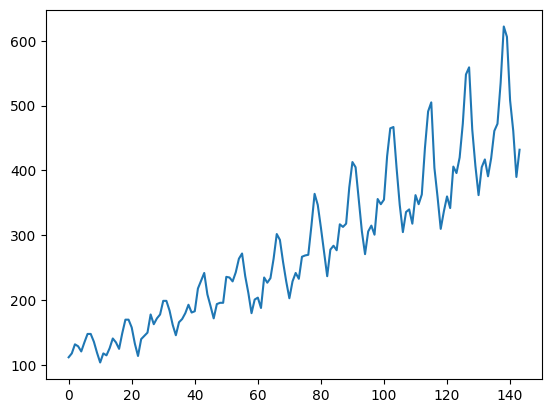

In [ ]:
# load the dataset
dataframe = read_csv('/content/drive/MyDrive/Data/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [ ]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [ ]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [ ]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

In [ ]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [ ]:
#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#


In [ ]:

##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
print('Train...')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              24400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 6s - loss: 0.0578 - val_loss: 0.2937 - 6s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.0483 - val_loss: 0.2477 - 68ms/epoch - 23ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0405 - val_loss: 0.2047 - 76ms/epoch - 25ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0321 - val_loss: 0.1659 - 77ms/epoch - 26ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0252 - val_loss: 0.1302 - 61ms/epoch - 20ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0192 - val_loss: 0.0987 - 82ms/epoch - 27ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0146 - val_loss: 0.0719 - 75ms/epoch - 25ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0103 - val_loss: 0.0510 - 65ms/epoch - 22ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0077 - val_loss: 0.0359 - 82ms/epoch - 27ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0059 - val_loss: 0.0268 - 75ms/epoch - 25ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0053 - val_loss: 0.0228 - 97ms/epoch - 32ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0052 - val_loss: 0.0221 - 71ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0055 - va

In [ ]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 7ms/step


In [ ]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.80 RMSE
Test Score: 57.17 RMSE


In [ ]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

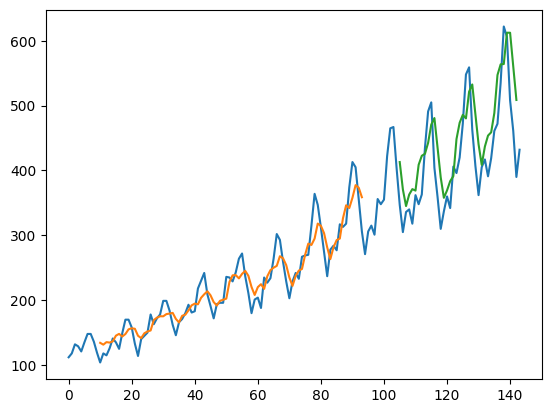

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()